# Introduction to mystic

## Introduction
- The mystic framework provides a collection of optimization algorithms and tools that allows the user to more robustly (and easily) solve hard optimization problems.

- It supports both i) derivative-free optimization and ii) constraints (This combination is not available in scipy).

- The mystic optimizers can be monitored and fine-tuned during the optimization process.

## This Talk

1. Introduction
2. Basic usage (minimal interface)
2. Basic usage (standard interface)
3. Constraints and Penalties
4. Stepmonitor
5. Available Solvers
6. My project


## Sources

- https://github.com/uqfoundation/mystic
- https://mystic.readthedocs.io/en/latest/index.html


In [1]:
import mystic
from mystic.models import rosen

import matplotlib.pyplot as plt
import numpy as np

### Basic usage (minimal interface)
- fmin (Nelder-Mead), fmin_powell
- scipy-interface
- Additional specifications as parameters of function call

In [2]:
# initial guess
x0 = [0.8, 1.2, 0.7]

# use Nelder-Mead to minimize the Rosenbrock function
solution = mystic.solvers.fmin(mystic.models.rosen, x0)
print(solution)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 215
[1.00000328 1.00000565 1.00001091]


In [3]:
solution = mystic.solvers.fmin(mystic.models.rosen, x0, disp=False ,maxiter=50)
print(solution)


[0.9388042  0.88149842 0.77720609]


### Basic usage (standard interface)
- object-oriented
- more flexibility

In [5]:
# Initial guess
x0 = [0.8, 1.2, 0.7]

solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)
solver.Solve(rosen, disp=True)

print(solver.bestSolution, solver.bestEnergy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 215
[1.00000328 1.00000565 1.00001091] 1.400759544790854e-10


In [6]:
from mystic.termination import CandidateRelativeTolerance as CRT
    
# Initial guess
x0 = [0.8, 1.2, 0.7]

# Bounds
lower_bound = [-100, -100, 1]       
upper_bound = [200, 100, np.inf]

solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)
solver.SetStrictRanges(lower_bound, upper_bound)
solver.Solve(rosen, CRT(xtol=4e-5), disp=1)
print(solver.bestSolution, solver.bestEnergy)

Optimization terminated successfully.
         Current function value: 3.987461
         Iterations: 113
         Function evaluations: 181
[-0.99367743  0.99746997  1.00000019] 3.987461065848986


### Constraints and Penalties

Two options to implement restrictions:
1. Constraints: 
    - “constrain” the solver to only searchin  regions of  solution  space  where the  constraints  are respected
    - xk’ = constraints(xk), where xk is the current parameter vector
2. Penalties:  
    - “penalize” regions of solution space that violate the constraint
    - y’ = penalty(xk), with y' = 0 if all constraints are satisfied

In [7]:
# Suppose we want to make sure that x1 + x2 + x3 = 3
def constraint(x):
    x[2] = 3 - x[0] - x[1]
    return x

def penalty(x):
    diff = np.sum(x) - 3
    return diff ** 2

In [8]:
# Initial guess
x0 = [0.8, 1.2, 0.7]

solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)
solver.SetConstraints(constraint)
solver.Solve(rosen)
print(solver.bestSolution, solver.bestEnergy)

[0.99998074 0.99998408 1.00003518] 5.008557044526953e-07


In [9]:
# Initial guess
x0 = [0.8, 1.2, 0.7]

solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)
solver.SetPenalty(penalty)
solver.Solve(rosen)
print(solver.bestSolution, solver.bestEnergy)

[0.99999052 0.9999771  0.99995072] 1.0055719994492852e-08


### Stepmonitor
It is also possible to ...
- run a solver step by step
- track current status of optimizations using a monitor
- interrupt a running optimization and restart it

In [55]:
# - run a solver step by step
solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)

while not solver.Terminated():
    solver.Step(rosen)
    print(solver.bestSolution, solver.bestEnergy)

[0.8 1.2 0.7] 86.19999999999997
[0.84 1.2  0.7 ] 79.26873599999999
[0.84  1.08  0.735] 32.66013199999988
[0.84  1.08  0.735] 32.66013199999988
[0.93333333 1.         0.71166667] 9.979290123456694
[0.91111111 0.93333333 0.76222222] 2.2632525529644276
[0.9362963  0.88888889 0.72592593] 0.44351333121830727
[0.9362963  0.88888889 0.72592593] 0.44351333121830727
[0.9362963  0.88888889 0.72592593] 0.44351333121830727
[0.9362963  0.88888889 0.72592593] 0.44351333121830727
[0.95245542 0.84958848 0.74827503] 0.42655220446171604
[0.93292638 0.89637174 0.75005544] 0.3683852002012762
[0.95801631 0.85901806 0.74044191] 0.3677543272814026
[0.94204783 0.87860749 0.73609169] 0.15451074850100927
[0.9483928  0.86379379 0.74523569] 0.14842583981647284
[0.94120601 0.88175576 0.7453226 ] 0.1226249828196392
[0.94120601 0.88175576 0.7453226 ] 0.1226249828196392
[0.94222815 0.87347187 0.75301653] 0.04973254607775858
[0.94222815 0.87347187 0.75301653] 0.04973254607775858
[0.94222815 0.87347187 0.75301653] 0.04

In [56]:
# - track current status of optimizations using a monitor

stepmon = Monitor()
evalmon = Monitor()

solver = mystic.solvers.NelderMeadSimplexSolver(len(x0))
solver.SetInitialPoints(x0)

solver.SetEvaluationMonitor(evalmon)
solver.SetGenerationMonitor(stepmon)

solver.Solve(rosen)
print(solver.bestSolution, solver.bestEnergy)



[1.00000328 1.00000565 1.00001091] 1.400759544790854e-10


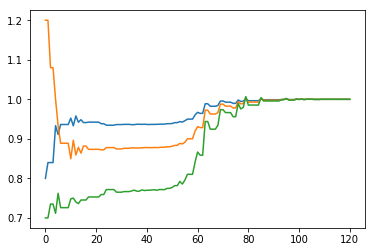

In [60]:
# plot the parameter trajectories
plt.plot([i[0] for i in stepmon.x])
plt.plot([i[1] for i in stepmon.x])
plt.plot([i[2] for i in stepmon.x])

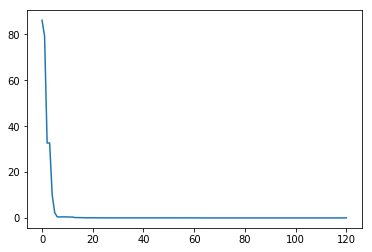

In [61]:
plt.plot(stepmon.y)

NOTE: while solver is running, press 'Ctrl-C' in console window
Press any key to continue and press enter


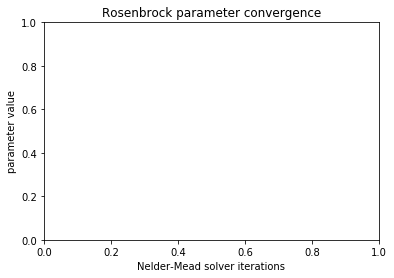

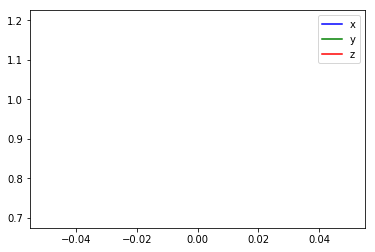

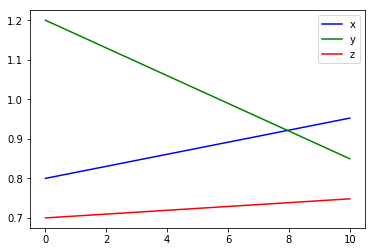

Traceback(filename='/home/christian/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py', lineno=34, function='_sum', code_context=['def _sum(a, axis=None, dtype=None, out=None, keepdims=False,\n'], index=0)
[]



 
 Enter sense switch.

    sol:  Print current best solution.
    cont: Continue calculation.
    call: Executes sigint_callback [None].
    exit: Exits with current best solution.

 >>>  sol


[0.94222815 0.87347187 0.75301653]



 
 Enter sense switch.

    sol:  Print current best solution.
    cont: Continue calculation.
    call: Executes sigint_callback [None].
    exit: Exits with current best solution.

 >>>  exit


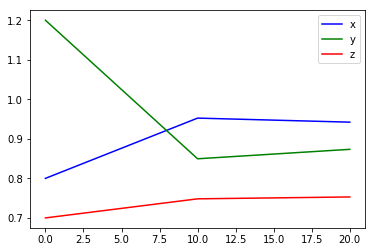

[0.94222815 0.87347187 0.75301653]
Press any key to continue and press enter


''

In [63]:
# - track current status of optimizations using a monitor
# - interrupt a running optimization and restart itfrom mystic.monitors import VerboseMonitor, Monitor

# Nelder-Mead solver
from mystic.solvers import fmin

# Rosenbrock function
from mystic.models import rosen

# tools
from mystic.tools import getch
import matplotlib.pyplot as plt
plt.ion()

# draw the plot
def plot_frame():
    plt.title("Rosenbrock parameter convergence")
    plt.xlabel("Nelder-Mead solver iterations")
    plt.ylabel("parameter value")
    plt.draw()
    plt.pause(0.001)
    return
 
iter = 0
step, xval, yval, zval = [], [], [], []
# plot the parameter trajectories
def plot_params(params):
    global iter, step, xval, yval, zval
    if iter % 10 == 0:
        step.append(iter)
        xval.append(params[0])
        yval.append(params[1])
        zval.append(params[2])
        plt.plot(step,xval,'b-')
        plt.plot(step,yval,'g-')
        plt.plot(step,zval,'r-')
        plt.legend(["x", "y", "z"])
        plt.draw()
    plt.pause(0.1)
    iter += 1
    return


# initial guess
x0 = [0.8, 1.2, 0.7]

# suggest that the user interacts with the solver
print("NOTE: while solver is running, press 'Ctrl-C' in console window")
getch()
plot_frame()

# use Nelder-Mead to minimize the Rosenbrock function
solution = fmin(rosen, x0, disp=1, callback=plot_params, handler=True)
print(solution)

# don't exit until user is ready
getch()



### Available Solvers

** Local-Search Optimizers **
- NelderMeadSimplexSolver      -- Nelder-Mead Simplex algorithm
- PowellDirectionalSolver      -- Powell's (modified) Level Set algorithm

** Pseudo-Global Optimizers **
- SparsitySolver               -- N Solvers sampled where point desity is low
- BuckshotSolver               -- Uniform Random Distribution of N Solvers
- LatticeSolver                -- Distribution of N Solvers on a Regular Grid

** Global Optimizers **

- DifferentialEvolutionSolver  -- Differential Evolution algorithm
- DifferentialEvolutionSolver2 -- Price & Storn's Differential Evolution


### My Project

- Estimate:
    - Ambiguity attitudes ($\tau$, $\sigma$)
    - Ambiguity neutral probabilites ($\pi_1$, $\pi_2$)
    - Trembling hand error ($\omega$)
- Using binary choice data between bets on the stock market (uncertainty) and lottery choices (risk)
- Model:         $$L(c_{E_1, p}^\text{AEX} |\pi_1, \pi_2, \sigma, \tau, \omega) =   \frac{\omega}{2} + (1 - \omega) 1_{\{\tau + \sigma \pi_1 > p\}}$$


In [1]:
import sys
sys.path.append("../ambig-beliefs")
from src.model_code.agent import (
    Agent, calc_decision_weight, likeli_one_choice, 
    penalty_one_choice, penalty_one_choice_parabola, choice_without_trembling
)
from src.analysis.main import ModelWithLikelihood


In [24]:
model = ModelWithLikelihood('omega_without_e0', 'opt_diff_evolution', use_sim_data=False)
agent = model.agents[800015]

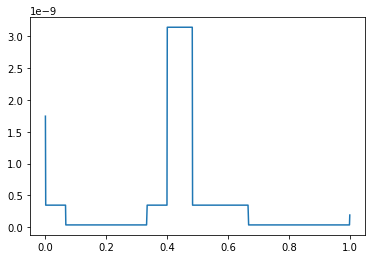

In [25]:
#pi_1
x = np.linspace(0, 1, 1000)
y = [agent.eval_likelihood({'pi_1':i, 'pi_2':0.6, 'tau':0.1, 'sigma':0.6, 'omega':0.2, 'theta':0}) for i in x]
plt.plot(x, y)

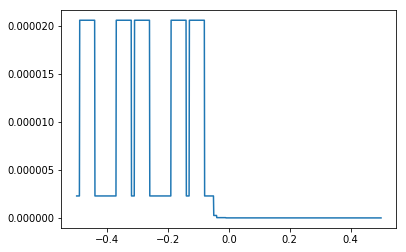

In [26]:
#tau
x = np.linspace(-0.5, 0.5, 1000)
y = [agent.eval_likelihood({'pi_1':0.1, 'pi_2':0.6, 'tau':i, 'sigma':0.6, 'omega':0.2, 'theta':0}) for i in x]
plt.plot(x, y)

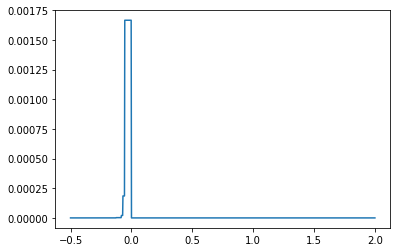

In [27]:
#sigma
x = np.linspace(-0.5, 2, 1000)
y = [agent.eval_likelihood({'pi_1':0.1, 'pi_2':0.6, 'tau':0.1, 'sigma':i, 'omega':0.2, 'theta':0}) for i in x]
plt.plot(x, y)

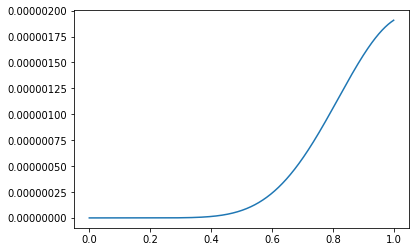

In [28]:
#omega
x = np.linspace(0, 1, 1000)
y = [agent.eval_likelihood({'pi_1':0.1, 'pi_2':0.6, 'tau':0.1, 'sigma':0.6, 'omega':i, 'theta':0}) for i in x]
plt.plot(x, y)